## Install Requirements

In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
!pip install kagglehub
!pip install langdetect
!pip install transformers
!pip install datasets
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 26.7 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=582b87671c14271d285913c5cff538142769ae9f85782e6c8221641140eb5ace
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platf

## Import Libraries

In [3]:
import os
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("WANDB_API_KEY")
os.environ["WANDB_API_KEY"] = api_key
os.environ["WANDB_PROJECT"] = 'nlp'

import re
import wandb
import kagglehub
import numpy as np
import pandas as pd
from langdetect import detect
from datasets import DatasetDict, Dataset
from transformers import DistilBertConfig, DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns

2025-05-10 22:27:28.225953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746916048.498451      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746916048.572398      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data loading and preprocessing

In [4]:
# Download dataset
def load_dataset(used_column):
    dataset_path = kagglehub.dataset_download("tobiasbueck/multilingual-customer-support-tickets")
    print("dataset downloaded to this path:", dataset_path)
    ds = pd.read_csv(os.path.join(dataset_path,'aa_dataset-tickets-multi-lang-5-2-50-version.csv'),usecols=used_column)
    ds = ds.rename(columns={'queue': 'label'})
    return ds

# Cleansing text for unnecessary characters
def cleanse_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"\S+@\S+", "", text)
    text = re.sub(r"\b\d{10,}\b", "", text)
    text = text.replace('\n', ' ').replace('\r', ' ')
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Load dataset and retain necessary columns
used_column = ['body','queue','language']
ds = load_dataset(used_column)

# Check null label value and discard the value
if ds['label'].isnull().any():
    print('There are some rows that has null label value, discard the rows')
    ds = ds.dropna(subset=['label'])

# Cleansing the text
ds["body"] = ds['body'].apply(cleanse_text)

# Discard non-english text
ds = ds[ds['language'] == 'en']
ds = ds.drop(columns=['language'])#.reset_index(drop=False)

# Enumerate label
label2id = {label: idx for idx, label in enumerate(ds['label'].unique())}
ds['label'] = ds['label'].map(label2id)

# Reverse Enumerate label
id2label = {v: k for k, v in label2id.items()}

dataset downloaded to this path: /kaggle/input/multilingual-customer-support-tickets


## Display Statistics

In [11]:
# Display labels
print('Unique value for category:', ds['label'].unique())

# Check label distribution
print('\nLabel freq (percentage):', (ds['label'].value_counts(normalize=True) * 100).sort_index())

# Display total row number for each label
print('\nLabel freq (count):', ds['label'].value_counts().sort_index())

Unique value for category: [0 1 2 3 4 5 6 7 8 9]

Label freq (percentage): label
0    28.993757
1     5.018974
2     9.762517
3     3.139919
4     4.064145
5    18.808912
6    11.886400
7    14.750888
8     2.130004
9     1.444485
Name: proportion, dtype: float64

Label freq (count): label
0    4737
1     820
2    1595
3     513
4     664
5    3073
6    1942
7    2410
8     348
9     236
Name: count, dtype: int64


## Data Splitting and Oversampling

In [18]:
# Rebalance data by oversampling, we can oversample the entire class or only the minority class 
#    that has a number of records less than the average number of records of all classes
def rebalance_dataframe_by_oversampling(df, label_col='label', random_state=42):
    # Get the majority class size
    class_counts = df[label_col].value_counts()
    
    # Oversampling limit (All class or only minority class)
    # max_count = class_counts.max()  # All class
    max_count = int(df[label_col].value_counts().sum()/df[label_col].nunique())  # Only minority class

    # List to save oversampled data for each class
    balanced_dfs = []

    for label, count in class_counts.items():
        df_label = df[df[label_col] == label]
        
        if count < max_count:
            df_upsampled = resample(
                df_label,
                replace=True, # oversampling
                n_samples=max_count,
                random_state=random_state
            )
        else:
            df_upsampled = df_label

        balanced_dfs.append(df_upsampled)

    # Concat all balanced data
    df_balanced = pd.concat(balanced_dfs).sample(frac=1, random_state=random_state).reset_index(drop=True)
    return df_balanced

In [19]:
# Copy the original data, for fresh start fine-tuning execute from this cell
ds_ready = ds.copy()

# Split the dataset
train_ds, test_ds = train_test_split(ds_ready, test_size=0.3, random_state=42, stratify=ds_ready['label'])

# Oversampling minority class
train_ds = rebalance_dataframe_by_oversampling(train_ds)
print("Data distribution after oversampling:\n",train_ds['label'].value_counts())

# Convert to Huggingface dataset object
train_dataset = Dataset.from_pandas(train_ds.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_ds.reset_index(drop=True))
ready_dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

Data distribution after oversampling:
 label
0    3316
5    2151
7    1687
6    1359
8    1143
2    1143
3    1143
1    1143
9    1143
4    1143
Name: count, dtype: int64


## Tokenization

### Check the token length distribution, to determine the tokenizer parameter for the max_length property.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


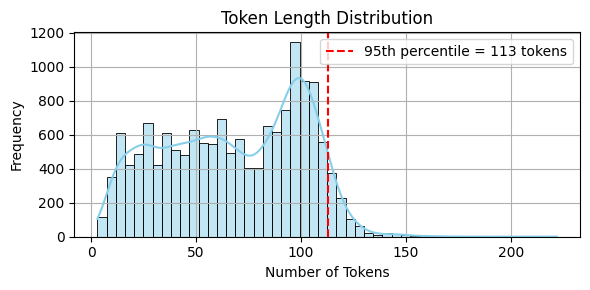

In [25]:
# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize without truncation to see actual lengths in train dataset
token_lengths = [len(tokenizer.encode(text, truncation=False)) for text in train_ds['body']]

# Get 95 percentile
percentile_95 = int(np.percentile(token_lengths, 95))

# Plot the token length distribution
plt.figure(figsize=(6, 3))
sns.histplot(token_lengths, bins=50, kde=True, color='skyblue')
plt.axvline(percentile_95, color='red', linestyle='--', label=f'95th percentile = {percentile_95} tokens')
plt.title('Token Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
# Define model name
model_name = 'distilbert-base-uncased'
# Define tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

# Configure tokenizer parameter and apply tokenizer to the data
def tokenize_function(datas):
    return tokenizer(datas["body"], padding="max_length", truncation=True, max_length=113)

# Apply tokenization to dataset
tokenized_dataset = ready_dataset.map(tokenize_function, batched=True)
# Set tokenized dataset to torch format
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Get label unique count
num_labels = train_ds['label'].nunique()

Map:   0%|          | 0/15371 [00:00<?, ? examples/s]

Map:   0%|          | 0/4902 [00:00<?, ? examples/s]

In [30]:
# Original model without focal loss
# model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Define metrics to calculate model performance, 
#  We calculate accuracy, f1, precision, and recall for each macro and weighted.
def compute_metrics(pred):
    logits = pred.predictions
    labels = pred.label_ids

    probs = softmax(logits, axis=1) 
    preds = np.argmax(probs, axis=1)

    # Accuracy
    acc = accuracy_score(labels, preds)

    # Macro
    macro_f1 = f1_score(labels, preds, average='macro')
    macro_precision = precision_score(labels, preds, average='macro', zero_division=0)
    macro_recall = recall_score(labels, preds, average='macro', zero_division=0)

    # Weighted
    weighted_f1 = f1_score(labels, preds, average='weighted')
    weighted_precision = precision_score(labels, preds, average='weighted', zero_division=0)
    weighted_recall = recall_score(labels, preds, average='weighted', zero_division=0)

    return {
        'accuracy': acc,
        'macro_f1': macro_f1,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'weighted_f1': weighted_f1,
        'weighted_precision': weighted_precision,
        'weighted_recall': weighted_recall
    }

# Get class weights based on label column
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_ds['label']),
    y=train_ds['label']
)

# Convert class weights to tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# We use focal loss because the label distribution is unbalanced, 
#   in the original dataset, there is a large difference between the major class and the minority.
# To avoid the model being biased toward majority classes and improves learning on minority or ambiguous classes
#
# Parameters and Variables:
#   The gamma number controls how much the loss focuses on hard-to-classify examples.
#   If gamma = 0 then the calculation of focal loss will be the same as the cross entropy loss.
#   pt is confidence score (model's estimated probability for the true class)
#   alpha is class weight
#   focal loss penalizes more when pt is low (hard class penalizes more)
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=1.0):
        super().__init__()
        self.alpha = alpha  # Class weights
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()

class DistilBERTWithFocalLoss(DistilBertForSequenceClassification):
    def __init__(self, config, class_weights, gamma=1.0):
        super().__init__(config)
        self.focal = FocalLoss(alpha=class_weights, gamma=gamma)

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss = self.focal(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Get original distilbert config
config = DistilBertConfig.from_pretrained(
    "distilbert-base-uncased", 
    # seq_classif_dropout=0.3, # Override default model classifier's dropout
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id)

# Implement focal loss
model = DistilBERTWithFocalLoss.from_pretrained(
    "distilbert-base-uncased",
    config=config,
    class_weights=class_weights_tensor
)

Some weights of DistilBERTWithFocalLoss were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Check model structure, config, and freeze layer if necessary

In [37]:
# Model Structure
print("Model Structure:=============================================")
print(model)

# Model Configuration
print("Model Config:=============================================")
print(model.config)

# Freeze all layer exclude the classifier
# for param in model.distilbert.parameters():
#     param.requires_grad = False

# Check trainable model parameters
print("Model trainable parameters:=============================================")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name}")

Model Structure:=============================================
DistilBERTWithFocalLoss(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
   

## Fine-Tuning Model


Fine-tuning


wandb: Currently logged in as: riutomo42 (riutomo42-student) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall,Weighted F1,Weighted Precision,Weighted Recall
1,1.698200,1.652184,0.399021,0.329088,0.391650,0.378678,0.364001,0.440052,0.399021
2,0.864500,1.438147,0.464300,0.454089,0.508737,0.452497,0.417136,0.460411,0.464300
3,0.788600,1.404568,0.497756,0.519627,0.594907,0.492601,0.489747,0.531528,0.497756
4,0.732200,1.355261,0.552428,0.565166,0.609866,0.545225,0.539795,0.554612,0.552428
5,0.383000,1.427047,0.571195,0.586628,0.672090,0.546248,0.568461,0.590121,0.571195
6,0.452800,1.442599,0.613627,0.617039,0.689931,0.572485,0.611285,0.626765,0.613627
7,0.299400,1.549260,0.622807,0.625994,0.692653,0.589998,0.623304,0.634730,0.622807
8,0.201100,1.615290,0.635659,0.631787,0.692209,0.596401,0.636184,0.647578,0.635659
9,0.073200,1.711518,0.644839,0.644766,0.706334,0.608003,0.645923,0.655970,0.644839
10,0.097900,1.757704,0.650551,0.643486,0.704144,0.607307,0.649811,0.657461,0.650551



Result


{'eval_loss': 1.7115180492401123, 'eval_accuracy': 0.6448388412892697, 'eval_macro_f1': 0.6447664336939346, 'eval_macro_precision': 0.706334050193618, 'eval_macro_recall': 0.6080031894203441, 'eval_weighted_f1': 0.6459227804417846, 'eval_weighted_precision': 0.6559698398962814, 'eval_weighted_recall': 0.6448388412892697, 'eval_runtime': 8.1156, 'eval_samples_per_second': 604.022, 'eval_steps_per_second': 18.976, 'epoch': 10.0}
                                 precision    recall  f1-score   support

              Technical Support       0.68      0.67      0.68      1421
          Returns and Exchanges       0.70      0.48      0.57       246
           Billing and Payments       0.85      0.79      0.82       479
            Sales and Pre-Sales       0.74      0.49      0.59       154
Service Outages and Maintenance       0.84      0.79      0.81       199
                Product Support       0.57      0.64      0.61       922
                     IT Support       0.60      0.57     

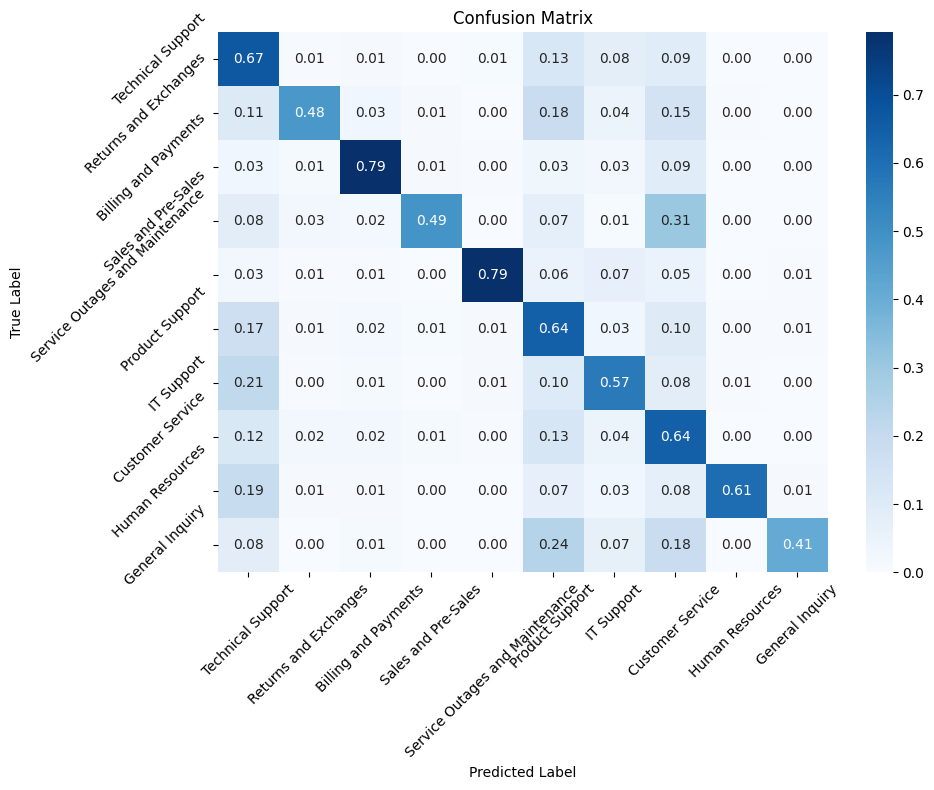

eval/accuracy,▁▃▄▅▆▇▇████
eval/loss,▆▂▂▁▂▃▄▆▇█▇
eval/macro_f1,▁▄▅▆▇▇█████
eval/macro_precision,▁▄▆▆▇██████
eval/macro_recall,▁▃▄▆▆▇▇████
eval/runtime,▁▆█▆▇▆▆▆▆▆▆
eval/samples_per_second,█▃▁▃▂▃▃▃▃▃▃
eval/steps_per_second,█▃▁▃▂▃▃▃▃▃▃
eval/weighted_f1,▁▂▄▅▆▇▇████
eval/weighted_precision,▁▂▄▅▆▇▇████
eval/weighted_recall,▁▃▄▅▆▇▇████


In [38]:
# Setup Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    # Number of training epoch
    num_train_epochs=10,
    # Weight decay penalizes large class weights to avoid overfitting
    weight_decay=0.1,
    # Learning rate controls how much the model's weights change with each update
    learning_rate=2e-5, 
    logging_dir="./logs",
    logging_steps=5,
    # Load the best model at the end of training
    load_best_model_at_end=True,
    # On this model, we focus on F1 Macro because it averages F1 score per class, treating each class equally.
    metric_for_best_model="macro_f1",
    # We use f1, so greater score is better
    greater_is_better=True,
    # We report training statistics to wandb cloud
    report_to="wandb",
    run_name="Version11",
    # Gradual increase learning rate for 500 step at the beginning
    warmup_steps=500,
    lr_scheduler_type="linear"
)

# Trainer definition
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics
)

# Do training
print("\nFine-tuning")
trainer.train()

# Evaluate training result for best model found
print("\nResult")
trainer_results = trainer.evaluate()
print(trainer_results)

# Display Classification Report
predictions = trainer.predict(tokenized_dataset["test"])
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)
label_names = [label for idx, label in sorted(id2label.items())]
print(classification_report(y_true, y_pred, target_names=label_names, digits=2))

# Display Confusion Matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Stop wandb run
wandb.finish()

## Optional Scripts

In [ ]:
# To remove kaggle output directory when full
!rm -rf /kaggle/working/*

In [ ]:
# To download the model

import shutil
model.save_pretrained("./my_distilbert_model_version12")
tokenizer.save_pretrained("./my_distilbert_model_version12")
shutil.make_archive("my_distilbert_model_version12", 'zip', "./my_distilbert_model_version12")
from IPython.display import FileLink
FileLink('my_distilbert_model_version12.zip')